In [1]:
import pandas as pd
from api import JolpicaF1API
from quali_plot_utils import plotQualiDrivers, plotQualiConstructors
from race_plot_utils import plotLapTimesBoxplot, plotMeanLapTimes, plotStdDevLapTimes
from utils import getConstructorColours, convertLapTimeToMs, convertToTimeFormat

In [2]:
api = JolpicaF1API()

In [3]:
constructorColors = getConstructorColours()

# Qualifying Analysis

In [4]:
qualiResults = api.getQualifyingResults('2024', 1)
qualiResults = qualiResults['MRData']['RaceTable']['Races']
qualiResults = qualiResults[0]['QualifyingResults']

qualiDf = pd.json_normalize(qualiResults, sep='_')

sessionList = ["Q1", "Q2", "Q3"]

for session in sessionList:
    qualiDf[f'{session}Ms'] = qualiDf[session].apply(convertLapTimeToMs)

sessionMsColumns = [f'{s}Ms' for s in sessionList]

if sessionMsColumns:
    qualiDf['fastestLapMs'] = qualiDf[sessionMsColumns].min(axis=1, skipna=True)
    qualiDf['fastestLap'] = qualiDf['fastestLapMs']

qualiDf['timeDiff'] = (qualiDf['fastestLapMs'] - qualiDf['fastestLapMs'].min()) / 6000
qualiDf = qualiDf.sort_values(by='timeDiff')
qualiDf['color'] = qualiDf['Constructor_name'].map(constructorColors)

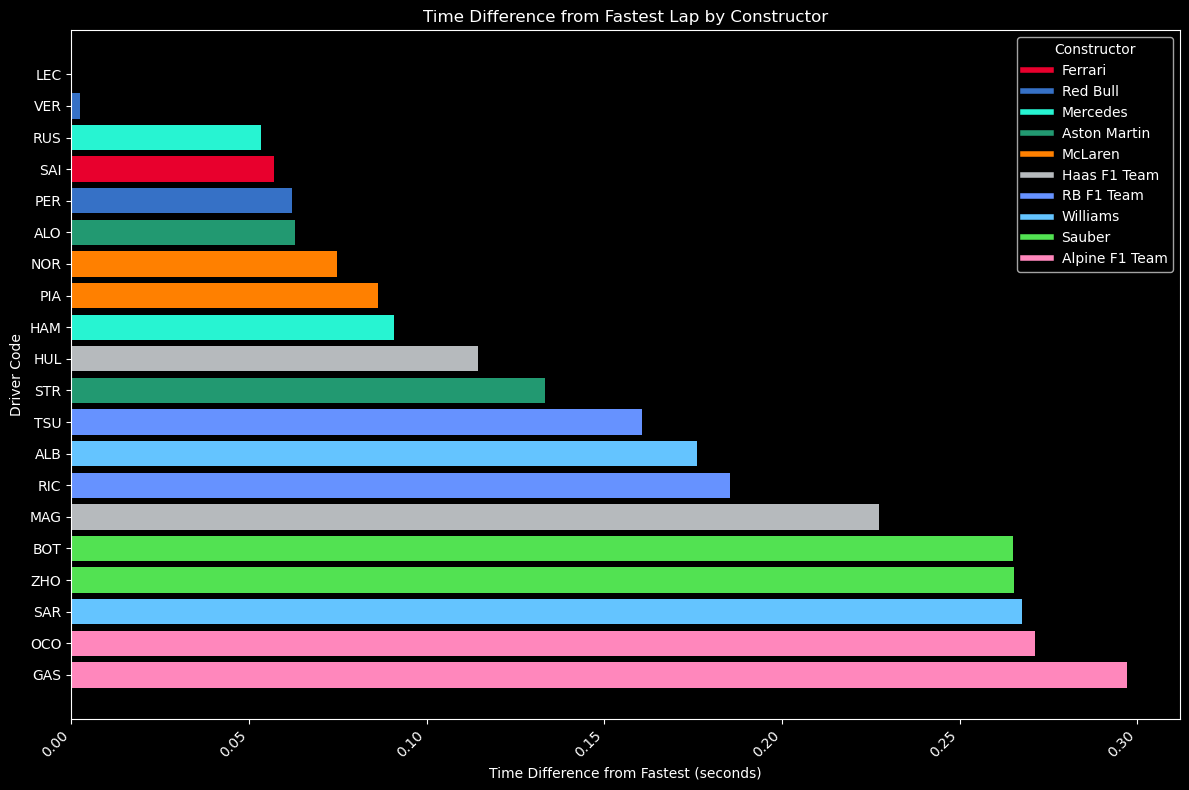

In [5]:
plotQualiDrivers(qualiDf)

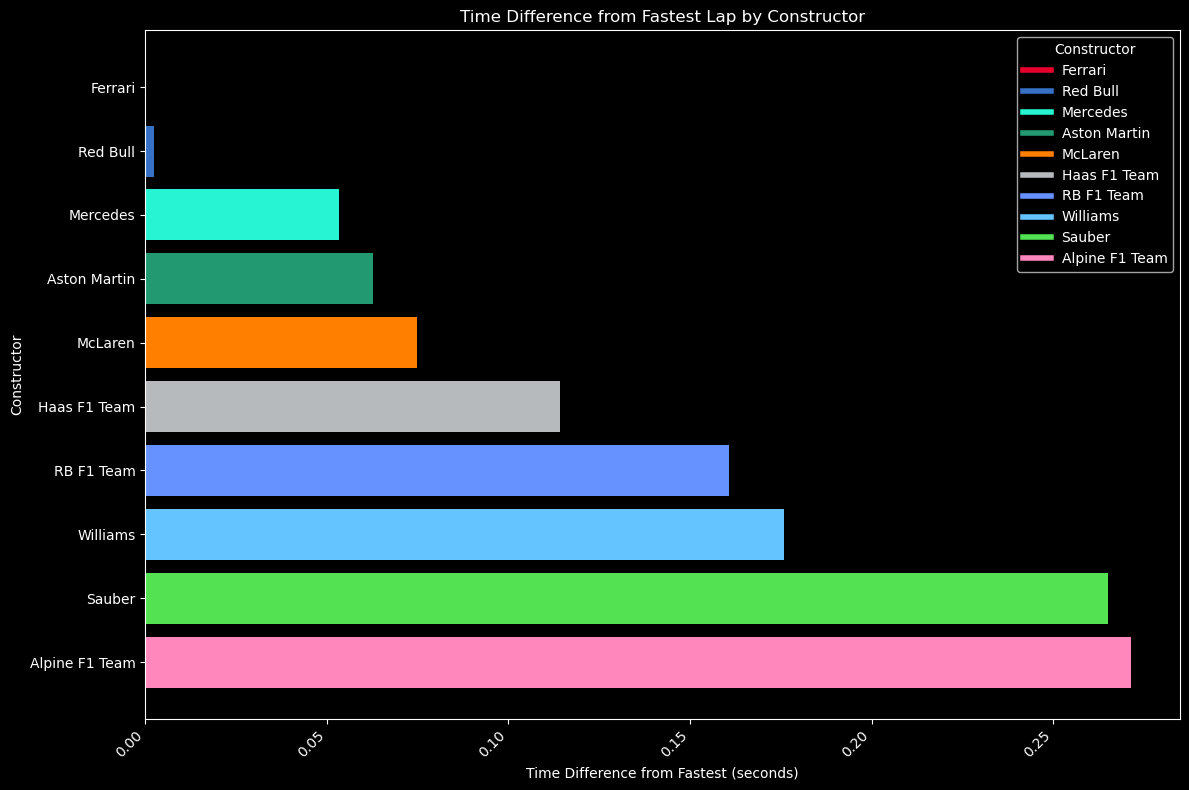

In [6]:
plotQualiConstructors(qualiDf)

# Race Analysis

In [7]:
raceResults = api.getLaps('2024', 1)
raceLaps = raceResults['MRData']['RaceTable']['Races'][0]['Laps']

⏳ Fetching 1129 race laps over 12 pages
Burst limit reached. Waiting 0.3 seconds
Burst limit reached. Waiting 0.2 seconds
Burst limit reached. Waiting 0.1 seconds
✅ Successfully fetched 57 race laps


In [8]:
lapTimingsDf = pd.json_normalize(raceLaps, record_path='Timings', meta=['number'])
lapTimingsDf['timeMs'] = lapTimingsDf['time'].apply(convertLapTimeToMs)
lapTimingsDf['timeMinutes'] = lapTimingsDf['timeMs'] / 60000

In [9]:
driverStandings = api.getDrivers('2024', 1)
driverData = driverStandings['MRData']['StandingsTable']['StandingsLists'][0]
driverDf = pd.json_normalize(driverData, record_path='DriverStandings')

Burst limit reached. Waiting 0.1 seconds


In [10]:
driverInfoDf = driverDf[['Driver.driverId', 'Driver.permanentNumber', 'Driver.code', 
                        'Driver.givenName', 'Driver.familyName', 'Constructors']]
driverInfoDf.columns = ['driverId', 'number', 'code', 'firstName', 'lastName', 'constructors']
driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(
    lambda x: x[0]['name'] if x else None
)
driverInfoDf = driverInfoDf[['driverId', 'number', 'code', 'firstName', 'lastName', 'constructor']]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_39968\3943629290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(


In [11]:
mergedRaceDf = pd.merge(lapTimingsDf, driverInfoDf, on='driverId', how='right')
mergedRaceDf = mergedRaceDf.rename(columns={'number_x': 'lap', 'number_y': 'driverNumber'})

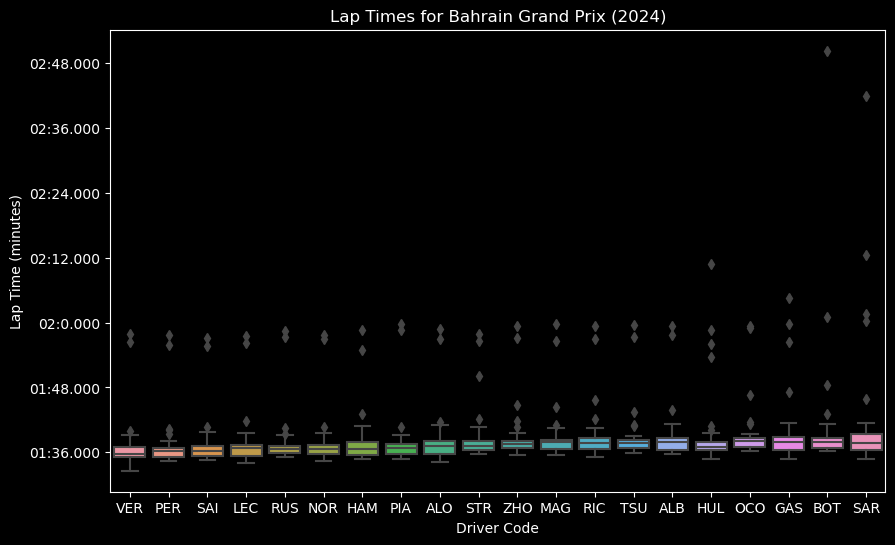

In [12]:
plotLapTimesBoxplot(mergedRaceDf)

In [13]:
pitStopData = api.getPitstops('2024', 1)
pitStops = pitStopData['MRData']['RaceTable']['Races'][0]['PitStops']
pitStopDf = pd.json_normalize(pitStops, sep=',')

In [14]:
mergedRaceDf['lap'] = mergedRaceDf['lap'].astype(int)
pitStopDf['lap'] = pitStopDf['lap'].astype(int)

In [15]:
mergedWithPitstops = pd.merge(mergedRaceDf, pitStopDf, on=['driverId', 'lap'], how='left', indicator=True)
mergedWithPitstops = mergedWithPitstops.rename(columns={'time_x': 'lapTime', 'time_y': 'pitStopTime'})

In [16]:
mergedWithPitstops['timeMs'] = pd.to_numeric(mergedWithPitstops['timeMs'], errors='coerce')
mergedWithPitstops['duration'] = pd.to_numeric(mergedWithPitstops['duration'], errors='coerce')
pitstop_adjustments = mergedWithPitstops[mergedWithPitstops['_merge'] == 'both'].copy()

In [17]:
pitstop_adjustments['lap'] = pitstop_adjustments['lap'] + 1
pitstop_adjustments['pitStopMs'] = pitstop_adjustments['duration'] * 1000

In [18]:
adjustedLapTimes = pd.merge(
    mergedRaceDf,
    pitstop_adjustments[['driverId', 'lap', 'pitStopMs']],
    on=['driverId', 'lap'],
    how='left',
    suffixes=('', '_adjustment')
)

In [19]:
adjustedLapTimes['adjustedTimeMs'] = adjustedLapTimes['timeMs'] - adjustedLapTimes['pitStopMs'].fillna(0)
adjustedLapTimes['adjustedTimeMinutes'] = adjustedLapTimes['adjustedTimeMs'] / 60000

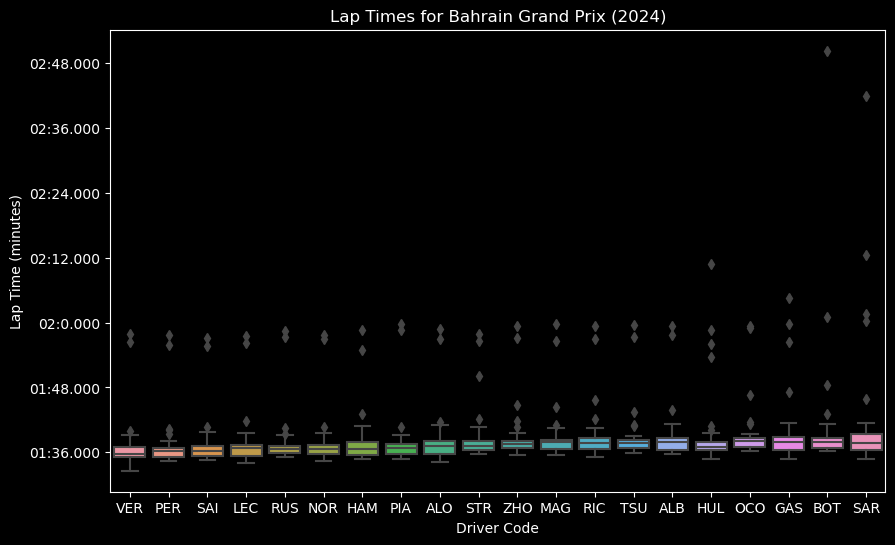

In [20]:
plotLapTimesBoxplot(adjustedLapTimes)

In [21]:
meanLapTimeMs = mergedRaceDf['timeMs'].mean()
stdLapTimeMs = mergedRaceDf['timeMs'].std()
meanLapTime = convertToTimeFormat(meanLapTimeMs)
stdLapTime = convertToTimeFormat(stdLapTimeMs)

In [22]:
meanLapTimeMsNoPitstops = adjustedLapTimes['adjustedTimeMs'].mean()
stdLapTimeMsNoPitstops = adjustedLapTimes['adjustedTimeMs'].std()
meanLapTimeNoPitstops = convertToTimeFormat(meanLapTimeMsNoPitstops)
stdLapTimeNoPitstops = convertToTimeFormat(stdLapTimeMsNoPitstops)

In [23]:
stats = mergedRaceDf.groupby(['driverId', 'firstName', 'lastName']).agg(
    meanTimeMs=('timeMs', 'mean'),
    stdTimeMs=('timeMs', 'std')
).reset_index()
stats['meanTime'] = stats['meanTimeMs'].apply(convertToTimeFormat)
stats['stdTime'] = stats['stdTimeMs'].apply(convertToTimeFormat)

In [24]:
stats_subset = stats[['firstName', 'lastName', 'meanTime', 'stdTime']]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
15,Carlos,Sainz,1:37.014,0:03.966
7,Charles,Leclerc,1:37.270,0:04.004
11,Sergio,Pérez,1:36.968,0:04.026
9,Lando,Norris,1:37.289,0:04.043
4,Lewis,Hamilton,1:37.457,0:04.049
14,George,Russell,1:37.395,0:04.096
19,Guanyu,Zhou,1:38.419,0:04.119
18,Yuki,Tsunoda,1:38.468,0:04.121
6,Kevin,Magnussen,1:38.447,0:04.122
0,Alexander,Albon,1:38.511,0:04.150


In [25]:
stats = adjustedLapTimes.groupby(['driverId', 'firstName', 'lastName']).agg(
    meanTimeMs=('adjustedTimeMs', 'mean'),
    stdTimeMs=('adjustedTimeMs', 'std')
).reset_index()
stats['meanTime'] = stats['meanTimeMs'].apply(convertToTimeFormat)
stats['stdTime'] = stats['stdTimeMs'].apply(convertToTimeFormat)

In [26]:
stats_subset = stats[['firstName', 'lastName', 'meanTime', 'stdTime']]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
12,Oscar,Piastri,1:36.543,0:01.309
14,George,Russell,1:36.524,0:01.314
9,Lando,Norris,1:36.431,0:01.398
8,Max,Verstappen,1:35.709,0:01.409
18,Yuki,Tsunoda,1:37.592,0:01.525
15,Carlos,Sainz,1:36.166,0:01.531
11,Sergio,Pérez,1:36.107,0:01.533
7,Charles,Leclerc,1:36.424,0:01.550
0,Alexander,Albon,1:37.631,0:01.647
19,Guanyu,Zhou,1:37.521,0:01.720


In [27]:
print("\nComparison of Mean Lap Times and Standard Deviations:")
print(f"1. Unfiltered Data      - Mean Lap Time: {meanLapTime}, Standard Deviation: {stdLapTime}")
print(f"2. Pitstops Removed     - Mean Lap Time: {meanLapTimeNoPitstops}, Standard Deviation: {stdLapTimeNoPitstops}")


Comparison of Mean Lap Times and Standard Deviations:
1. Unfiltered Data      - Mean Lap Time: 1:38.111, Standard Deviation: 0:05.332
2. Pitstops Removed     - Mean Lap Time: 1:37.162, Standard Deviation: 0:03.474


In [28]:
baseStats = mergedRaceDf.groupby(['driverId', 'firstName', 'lastName', 'constructor'])['timeMs'].agg(['mean', 'std']).reset_index()
baseStats.columns = ['driverId', 'firstName', 'lastName', 'constructor', f'baseMean', f'baseStd']

adjustedStats = adjustedLapTimes.groupby(['driverId', 'firstName', 'lastName', 'constructor'])['adjustedTimeMs'].agg(['mean', 'std']).reset_index()
adjustedStats.columns = ['driverId', 'firstName', 'lastName', 'constructor', f'adjustedMean', f'adjustedStd']

In [29]:
combinedStats = pd.merge(baseStats, adjustedStats, on=['driverId', 'firstName', 'lastName', 'constructor'])
finalStats = combinedStats[['firstName', 'lastName', 'constructor', 'baseMean', 'baseStd', 'adjustedMean', 'adjustedStd']]

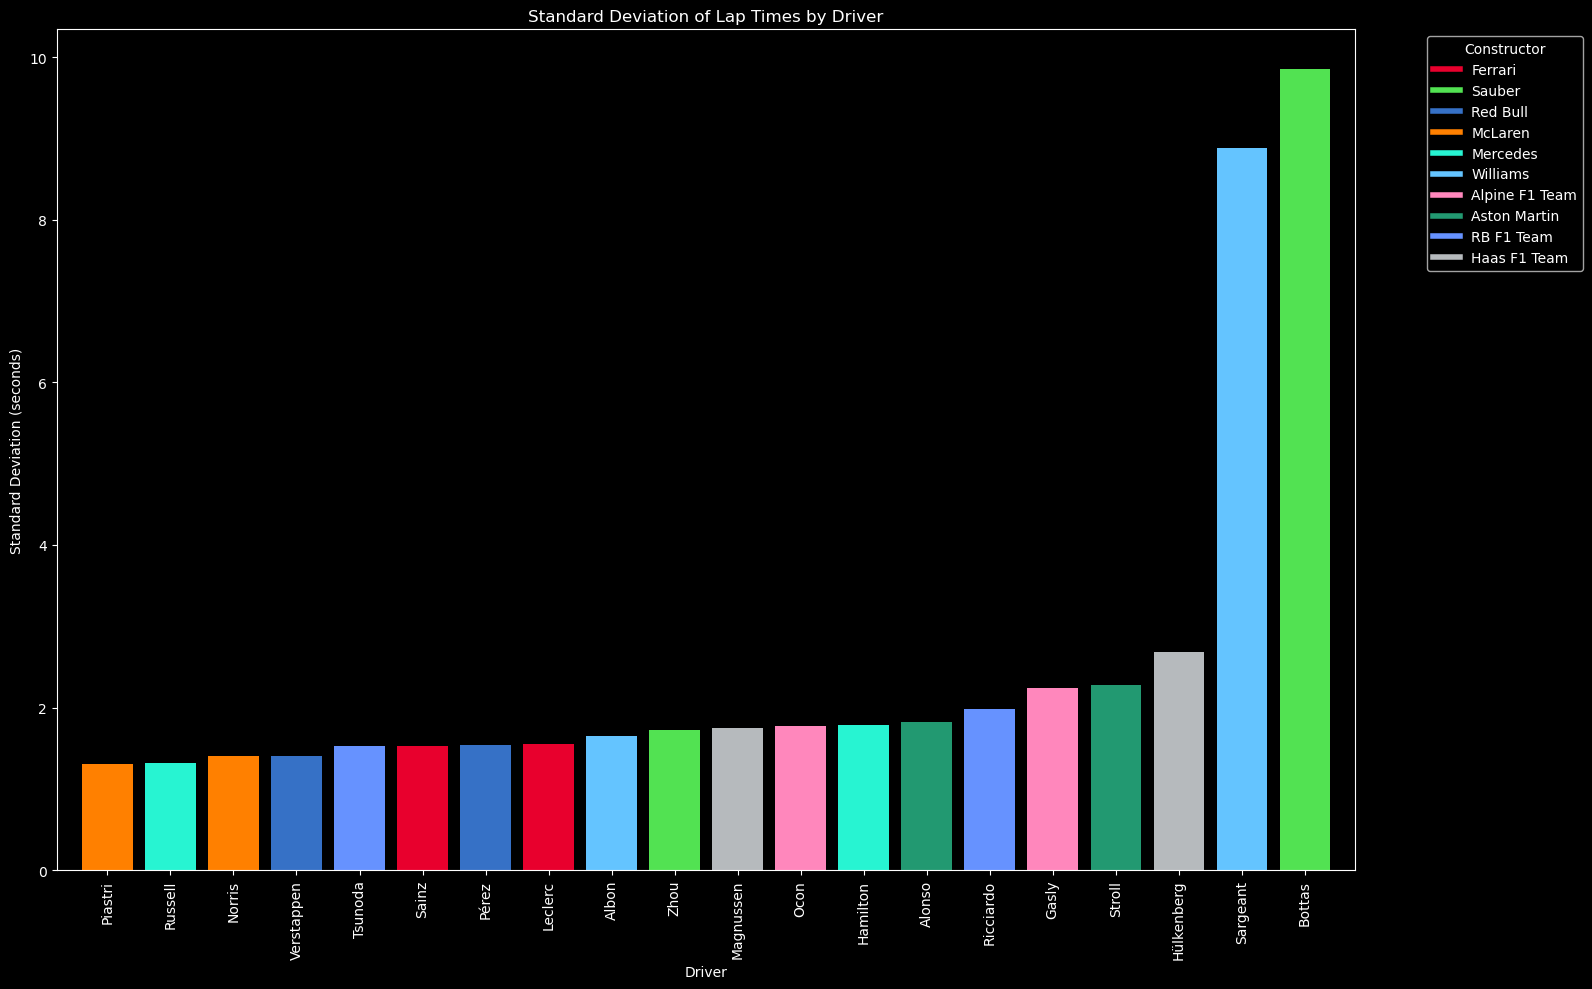

In [30]:
plotStdDevLapTimes(finalStats, constructorColors)

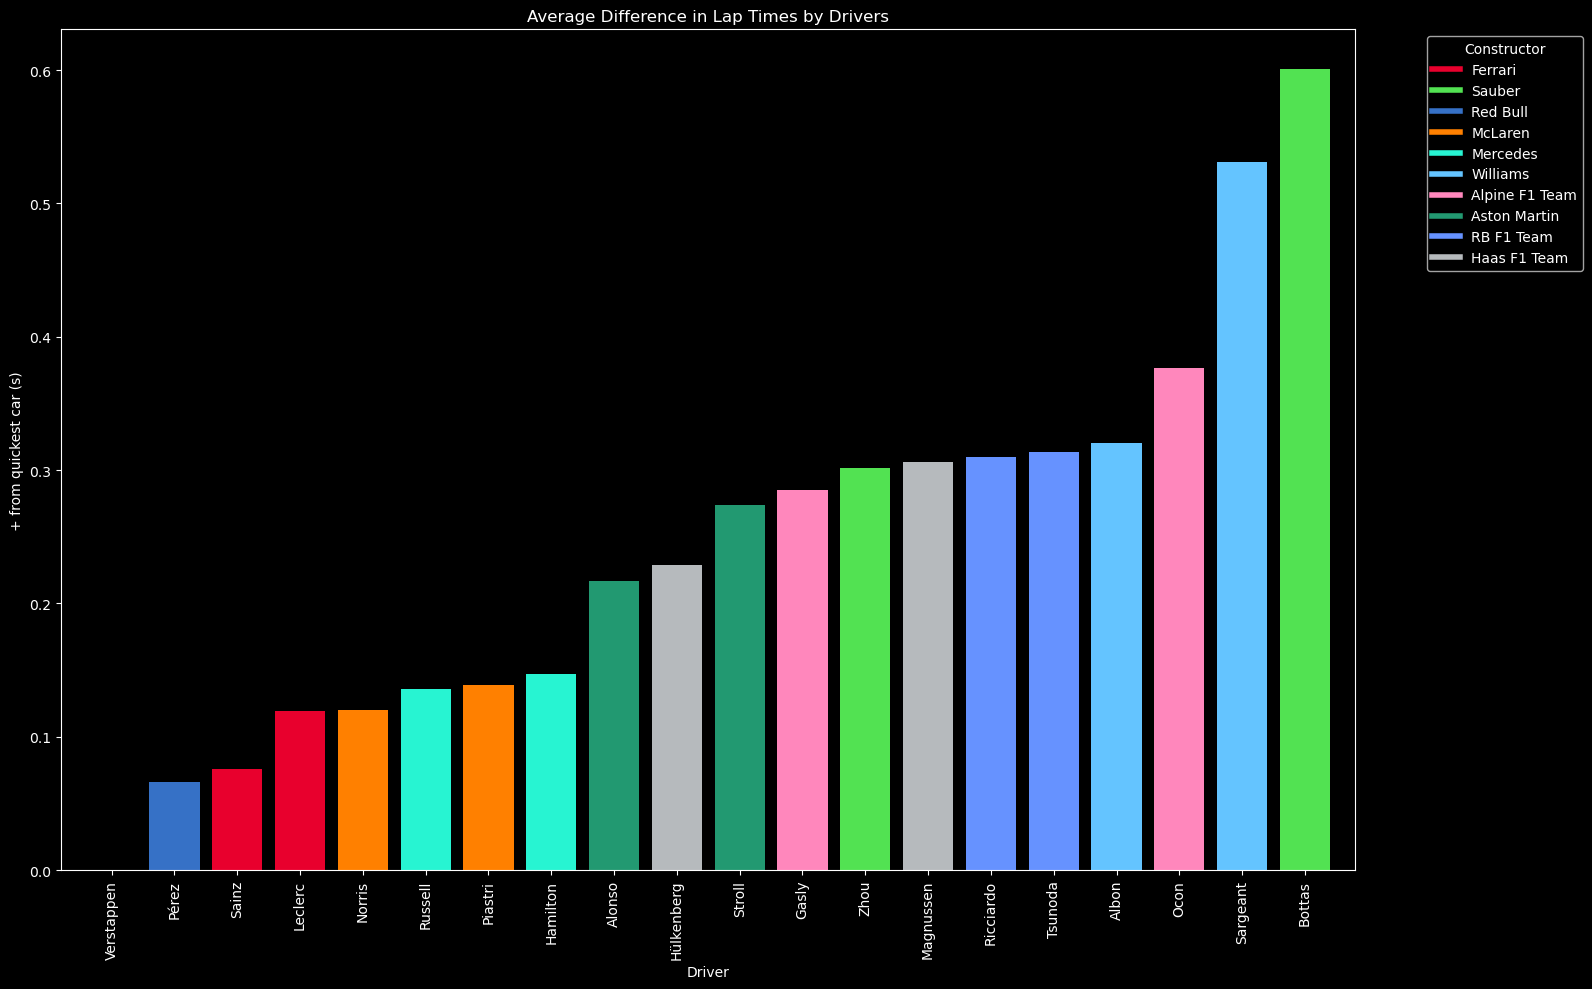

In [31]:
plotMeanLapTimes(finalStats, constructorColors)